In [1]:
import re
import itertools
from collections import Counter
import pandas as pd
import string

import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download()
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
    
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

/home/kai/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import re
import ast
import itertools
from collections import Counter
import pandas as pd
import numpy as np
import scipy.sparse as sparse

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

from IPython.display import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

## Constant

In [3]:
itemID = 'asin'
userID = 'reviewerID'
rating = 'overall'
reviewText = 'reviewText'
summary = 'summary'
keyPhrase = 'keyVector'
binary = 'Binary'
helpful = 'helpful'
helpful_rating = 'helpful_rating'
total_helpful = 'total_helpful'
overall = 'overall'
dataPath = 'data/ToysGames/'
dataName = 'reviews_Toys_and_Games_5.json.gz'

## Load Data

In [4]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(dataPath+dataName)[[userID, itemID, helpful, reviewText, overall, summary]]
df[reviewText] = df[reviewText].astype('str')
df[summary] = df[summary].astype('str')
df[helpful] = df[helpful].astype('str')

In [5]:
df[df[reviewText].isnull()]

,reviewerID,asin,helpful,reviewText,overall,summary


In [6]:
#function to filter for ADJ tokens
def rightTypes(token):
    acceptable_types = ('JJ', 'JJR', 'JJS')
    tags = nltk.pos_tag(token)
    
    if tags[0][1] in acceptable_types:
        return True
    else:
        return False

In [7]:
def expand_token(df, col, expand_col):
    lens = [len(item) for item in df[expand_col]]
    return pd.DataFrame( {col : np.repeat(df[col].values,lens), 
                          expand_col : np.concatenate(df[expand_col].values)})

In [8]:
# Tokenize Review
df["review_word_tokenized"] = df[reviewText].apply(lambda x: nltk.word_tokenize(x)+[' '])

# Remove Stopwords
# Get english stopwords
en_stopwords = set(stopwords.words('english'))
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [w for w in text if w not in en_stopwords])

# Remove Punctuation
table = str.maketrans('', '', string.punctuation)
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [w.translate(table) for w in text])
    
# Remove tokens that are not alphabetic
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [w for w in text if w.isalpha()])

# Lowercase
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [w.lower() for w in text])

In [9]:
def process_dataset(df, use_lemmatizer=True, 
                    remove_user=True, num_user=10000, filter_user_criteria="num_reviews", 
                    remove_item=True, num_item=10000, filter_item_criteria="num_reviews", 
                    filter_by_type=True, freq_filter=100, num_keyPhrases=100):
    print("use_lemmatizer {}, num_user {}, filter_user_criteria {}, num_item {}, filter_item_criteria {}, filter_by_type {}, freq_filter {}".format(use_lemmatizer, num_user, filter_user_criteria, num_item, filter_item_criteria, filter_by_type, freq_filter))
    
    if use_lemmatizer:
        # Lemmatizing
        lemmatizer = WordNetLemmatizer()
        df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                        [lemmatizer.lemmatize(w) for w in text])
    else:
        # Stemming
        porter = PorterStemmer()
        df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                        [porter.stem(w) for w in text])
    
    if remove_user:
        df_user = df.groupby(userID, as_index=False).agg(lambda x: x.tolist())
        if filter_user_criteria == "num_reviews":
            df_user["num_reviews"] = df_user["review_word_tokenized"].str.len()
            df_user = df_user.sort_values("num_reviews", ascending=False)
            df_user.hist(column="num_reviews")
#             print("User DF head after filtered: \n {} \n".format(df_user.head(10)["num_reviews"]))
        elif filter_user_criteria == "num_words_in_reviews":
            df_user["review_word_tokenized"] = df_user["review_word_tokenized"]. \
                                                    apply(lambda l: [item for sublist in l for item in sublist])
            df_user["num_words_in_reviews"] = df_user["review_word_tokenized"].str.len()
            df_user = df_user.sort_values("num_words_in_reviews", ascending=False)
            df_user.hist(column="num_words_in_reviews")
#             print("User DF head after filtered: \n {} \n".format(df_user.head(10)["num_words_in_reviews"]))
        else:
            df_user["review_word_tokenized"] = df_user["review_word_tokenized"]. \
                                                    apply(lambda l: [item for sublist in l for item in sublist])
            df_user["review_word_tokenized"] = df_user["review_word_tokenized"].apply(lambda l: list(set(l)))
            df_user["num_unique_words_in_reviews"] = df_user["review_word_tokenized"].str.len()
            df_user = df_user.sort_values("num_unique_words_in_reviews", ascending=False)
            df_user.hist(column="num_unique_words_in_reviews")
#             print("User DF head after filtered: \n {} \n".format(df_user.head(10)["num_unique_words_in_reviews"]))

        filtered_userID = df_user.head(num_user)[userID].values
        df = df.loc[df[userID].isin(filtered_userID)]
    
    if remove_item:
        df_item = df.groupby(itemID, as_index=False).agg(lambda x: x.tolist())
        if filter_item_criteria == "num_reviews":
            df_item["num_reviews"] = df_item["review_word_tokenized"].str.len()
            df_item = df_item.sort_values("num_reviews", ascending=False)
            df_item.hist(column="num_reviews")
#             print("Item DF head after filtered: \n {} \n".format(df_item.head(10)["num_reviews"]))
        elif filter_item_criteria == "num_words_in_reviews":
            df_item["review_word_tokenized"] = df_item["review_word_tokenized"]. \
                                                    apply(lambda l: [item for sublist in l for item in sublist])
            df_item["num_words_in_reviews"] = df_item["review_word_tokenized"].str.len()
            df_item = df_item.sort_values("num_words_in_reviews", ascending=False)
            df_item.hist(column="num_words_in_reviews")
#             print("Item DF head after filtered: \n {} \n".format(df_item.head(10)["num_words_in_reviews"]))
        else:
            df_item["review_word_tokenized"] = df_item["review_word_tokenized"]. \
                                                    apply(lambda l: [item for sublist in l for item in sublist])
            df_item["review_word_tokenized"] = df_item["review_word_tokenized"].apply(lambda l: list(set(l)))
            df_item["num_unique_words_in_reviews"] = df_item["review_word_tokenized"].str.len()
            df_item = df_item.sort_values("num_unique_words_in_reviews", ascending=False)
            df_item.hist(column="num_unique_words_in_reviews")
#             print("Item DF head after filtered: \n {} \n".format(df_item.head(10)["num_unique_words_in_reviews"]))

        filtered_itemID = df_item.head(num_item)[itemID].values
        df = df.loc[df[itemID].isin(filtered_itemID)]
      
    # Get word index
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df["review_word_tokenized"].values)
    df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])
    
    df_pmi = df[["asin", "review_word_tokenized"]]
    
    df_pmi = expand_token(df_pmi, col="asin", expand_col="review_word_tokenized")
    
    co_occur_df = df_pmi.groupby(["asin", "review_word_tokenized"]).size().reset_index(name="Co-occur")
    
    values = df_pmi['asin'].value_counts().keys().tolist()
    counts = df_pmi['asin'].value_counts().tolist()
    asin_df = pd.DataFrame.from_dict({"asin": values, "count_asin": counts})
    
    values = df_pmi['review_word_tokenized'].value_counts().keys().tolist()
    counts = df_pmi['review_word_tokenized'].value_counts().tolist()
    review_df = pd.DataFrame.from_dict({"review_word_tokenized": values, "count_review_word_tokenized": counts})
    
    df_pmi = pd.merge(df_pmi, asin_df, on='asin', how='left')
    df_pmi = pd.merge(df_pmi, review_df, on='review_word_tokenized', how='left')
    df_pmi = pd.merge(df_pmi, co_occur_df, on=['asin', 'review_word_tokenized'], how='left')

#     # Get all tokens
#     token_list = df["review_word_tokenized"].values
    
#     # Get bigrams
#     bigrams = nltk.collocations.BigramAssocMeasures()
#     tokens = itertools.chain.from_iterable(token_list)
#     bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

#     bigram_freq = bigramFinder.ngram_fd.items()
#     bigramFreqTable = pd.DataFrame(list(bigram_freq), 
#                                    columns=['ngram','freq']).sort_values(by='freq', ascending=False)
# #     print("Bigram Freq Head: \n {} \n".format(bigramFreqTable.head(50)))
    
#     bigramFinder.apply_freq_filter(freq_filter)
#     bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
#                                   columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
    
#     if filter_by_type:
#         bigramPMITable = bigramPMITable[bigramPMITable.bigram.map(lambda x: rightTypes(x))]

#     bigram_freq_pmi = pd.merge(bigramFreqTable, bigramPMITable, how='right', left_on='ngram', right_on='bigram'). \
#                             sort_values("PMI", ascending=False)
#     print("Bigram Freq PMI Head: \n {} \n".format(bigram_freq_pmi.head(20)))
#     print("Biagram Freq PMI Head Total Freq: {} \n".format(bigram_freq_pmi.head(num_keyPhrases)['freq'].sum()))
#     print("Biagram Freq PMI Head Total PMI: {} \n".format(bigram_freq_pmi.head(num_keyPhrases)['PMI'].sum()))
    
#     df_keyphrases = bigram_freq_pmi[['bigram']].head(num_keyPhrases)
#     df_keyphrases['Phrases'] = df_keyphrases['bigram'].apply(lambda x: ' '.join(x))
#     df_keyphrases = df_keyphrases[['Phrases']].reset_index(drop=True)
#     keyphrases = df_keyphrases['Phrases'].tolist()
    
#     df["keyVector"] = df[reviewText].apply(lambda x: [keyphrases.index(key) for key in keyphrases if key in x])
#     df['keyphrases_indices_length'] = df['keyVector'].str.len()
    
#     print("Total number of keyphrases hit is: {} \n".format(df['keyphrases_indices_length'].sum()))
#     print("The ratio of keyphrases hit is: {} \n".format(df['keyphrases_indices_length'].sum() / len(df)))
    
#     df.hist(column='keyphrases_indices_length')
    
#     df['UserIndex'] = df[userID].astype('category').cat.rename_categories(range(0, df[userID].nunique()))
#     df['ItemIndex'] = df[itemID].astype('category').cat.rename_categories(range(0, df[itemID].nunique()))
#     df['Binary'] = (df[rating] > 3)*1
    
#     df_user_name = df[['UserIndex',userID]]
#     df_item_name = df[['ItemIndex',itemID]]
    
#     print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
#     print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
#     print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))
#     print("Number of key Phrase: {0}".format(num_keyPhrases))
#     print("Number of reviews: {0}".format(len(df)))
    
#     df.to_csv(dataPath+'Data.csv')
#     df_word_index.to_csv(dataPath+'WordIndex.csv')
#     df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
#     df_user_name.to_csv(dataPath+'UserIndex.csv')
#     df_item_name.to_csv(dataPath+'ItemIndex.csv')
    
# #     %run ./main.py -d data/ToysGames/
    
    return df_pmi, co_occur_df, asin_df, review_df

use_lemmatizer False, num_user 10000, filter_user_criteria num_reviews, num_item 8000, filter_item_criteria num_reviews, filter_by_type False, freq_filter 300


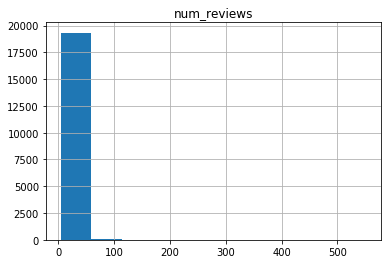

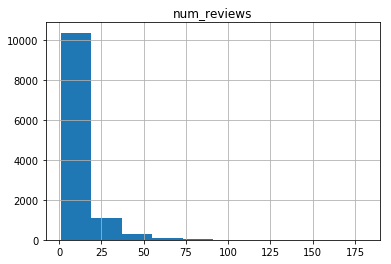

In [10]:
# for use_lemmatizer in [True]:
#     for num_user in [10000, 8000]:
#         for filter_user_criteria in ["num_reviews", "num_words_in_reviews", "num_unique_words_in_reviews"]:
#             for num_item in [8000, 6000, 4000]:
#                 for filter_item_criteria in ["num_reviews", "num_words_in_reviews", "num_unique_words_in_reviews"]:
#                     for filter_by_type in [True, False]:
#                         for freq_filter in [600, 1000]:
#                             df_cur = process_dataset(df, use_lemmatizer=use_lemmatizer,  
#                                                      remove_user=True, num_user=num_user, 
#                                                      filter_user_criteria=filter_user_criteria, 
#                                                      remove_item=True, num_item=num_item, 
#                                                      filter_item_criteria=filter_item_criteria, 
#                                                      filter_by_type=filter_by_type, 
#                                                      freq_filter=freq_filter, num_keyPhrases=100)

df_pmi, co_occur_df, asin_df, review_df = process_dataset(df, use_lemmatizer=False, 
                remove_user=True, num_user=10000, filter_user_criteria="num_reviews", 
                remove_item=True, num_item=8000, filter_item_criteria="num_reviews", 
                filter_by_type=False, freq_filter=300, num_keyPhrases=100)

In [11]:
df_pmi.head()

,asin,review_word_tokenized,count_asin,count_review_word_tokenized,Co-occur
0,0439893577,both,407,1333,2
1,0439893577,side,407,6856,4
2,0439893577,magnet,407,2204,18
3,0439893577,a,407,7347,2
4,0439893577,real,407,5094,1


In [18]:
def return_type(df):
    return nltk.pos_tag(df["review_word_tokenized"])

In [12]:
def calculate_approx_pmi(df):
    return np.log(df["Co-occur"] / (df["count_asin"] * df["count_review_word_tokenized"]))

In [15]:
df_pmi_approx = df_pmi[df_pmi["Co-occur"] >= 100]
df_pmi_approx["approx_pmi"] = df_pmi_approx.apply(calculate_approx_pmi, axis=1)

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
df_pmi_approx.sort_values("approx_pmi", ascending=False)

,asin,review_word_tokenized,count_asin,count_review_word_tokenized,Co-occur,approx_pmi
6218130,B00D9LWJTC,jinn,3788,102,100,-8.259396
6216768,B00D9LWJTC,jinn,3788,102,100,-8.259396
6217037,B00D9LWJTC,jinn,3788,102,100,-8.259396
6217021,B00D9LWJTC,jinn,3788,102,100,-8.259396
6217005,B00D9LWJTC,jinn,3788,102,100,-8.259396
6216970,B00D9LWJTC,jinn,3788,102,100,-8.259396
6216923,B00D9LWJTC,jinn,3788,102,100,-8.259396
6216898,B00D9LWJTC,jinn,3788,102,100,-8.259396
6216885,B00D9LWJTC,jinn,3788,102,100,-8.259396
6216879,B00D9LWJTC,jinn,3788,102,100,-8.259396


In [19]:
df_pmi_approx["type"] = df_pmi_approx.apply(return_type, axis=1)

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_pmi_approx

,asin,review_word_tokenized,count_asin,count_review_word_tokenized,Co-occur,approx_pmi,type
1611,073533417X,i,4918,212881,113,-16.041758,"[(i, NN)]"
1616,073533417X,puzzl,4918,16272,263,-12.625704,"[(p, NN), (u, JJ), (z, NNP), (z, NN), (l, NN)]"
1622,073533417X,puzzl,4918,16272,263,-12.625704,"[(p, NN), (u, JJ), (z, NNP), (z, NN), (l, NN)]"
1635,073533417X,puzzl,4918,16272,263,-12.625704,"[(p, NN), (u, JJ), (z, NNP), (z, NN), (l, NN)]"
1641,073533417X,piec,4918,28452,173,-13.603339,"[(p, NN), (i, NN), (e, VBP), (c, NNS)]"
1650,073533417X,piec,4918,28452,173,-13.603339,"[(p, NN), (i, NN), (e, VBP), (c, NNS)]"
1664,073533417X,piec,4918,28452,173,-13.603339,"[(p, NN), (i, NN), (e, VBP), (c, NNS)]"
1671,073533417X,puzzl,4918,16272,263,-12.625704,"[(p, NN), (u, JJ), (z, NNP), (z, NN), (l, NN)]"
1672,073533417X,i,4918,212881,113,-16.041758,"[(i, NN)]"
1676,073533417X,piec,4918,28452,173,-13.603339,"[(p, NN), (i, NN), (e, VBP), (c, NNS)]"


In [22]:
nltk.pos_tag(df_pmi_approx["review_word_tokenized"])

[('i', 'NN'),
 ('puzzl', 'VBP'),
 ('puzzl', 'NN'),
 ('puzzl', 'NN'),
 ('piec', 'NN'),
 ('piec', 'NN'),
 ('piec', 'NN'),
 ('puzzl', 'NN'),
 ('i', 'NN'),
 ('piec', 'VBP'),
 ('i', 'NN'),
 ('puzzl', 'VBP'),
 ('piec', 'NN'),
 ('puzzl', 'VBP'),
 ('the', 'DT'),
 ('piec', 'NN'),
 ('puzzl', 'NN'),
 ('piec', 'NN'),
 ('puzzl', 'NN'),
 ('piec', 'NN'),
 ('piec', 'NN'),
 ('puzzl', 'NN'),
 ('i', 'NN'),
 ('puzzl', 'VBP'),
 ('puzzl', 'NN'),
 ('i', 'NN'),
 ('puzzl', 'VBP'),
 ('the', 'DT'),
 ('piec', 'NN'),
 ('the', 'DT'),
 ('puzzl', 'NN'),
 ('puzzl', 'NN'),
 ('puzzl', 'IN'),
 ('the', 'DT'),
 ('piec', 'NN'),
 ('i', 'NN'),
 ('piec', 'VBP'),
 ('i', 'IN'),
 ('the', 'DT'),
 ('puzzl', 'NN'),
 ('piec', 'NN'),
 ('piec', 'NN'),
 ('puzzl', 'NN'),
 ('piec', 'NN'),
 ('puzzl', 'NN'),
 ('piec', 'NN'),
 ('puzzl', 'NN'),
 ('i', 'NN'),
 ('piec', 'VBP'),
 ('puzzl', 'NN'),
 ('i', 'NN'),
 ('piec', 'VBP'),
 ('puzzl', 'NN'),
 ('puzzl', 'NN'),
 ('piec', 'NN'),
 ('puzzl', 'NN'),
 ('i', 'VBP'),
 ('the', 'DT'),
 ('piec', 'NN'),


In [23]:
df_pmi["PMI"] = df_pmi.apply(calculate_pmi, axis=1)

In [ ]:
df_pmi = df_pmi.sort_values("PMI", ascending=False)

In [25]:
# nltk.pos_tag(ngram)
# df_pmi["review_word_tokenized"].apply(nltk.pos_tag, axis=1)
nltk.pos_tag(df_pmi["review_word_tokenized"])

[('chou', 'NN'),
 ('woodstock', 'NN'),
 ('penbo', 'NN'),
 ('nevra', 'NN'),
 ('tasha', 'NN'),
 ('slurpee', 'NN'),
 ('dalmuti', 'NN'),
 ('trixie', 'NN'),
 ('zoomer', 'NN'),
 ('maisy', 'NN'),
 ('dimetrodon', 'NN'),
 ('julius', 'NN'),
 ('chica', 'NN'),
 ('saruman', 'NN'),
 ('lex', 'VBZ'),
 ('tyrone', 'NN'),
 ('llama', 'NN'),
 ('louisville', 'VBZ'),
 ('wrecky', 'JJ'),
 ('stormer', 'NN'),
 ('krillin', 'NN'),
 ('woozle', 'NN'),
 ('pricemarker', 'NN'),
 ('lbp', 'NN'),
 ('gubs', 'NNS'),
 ('oviraptor', 'VBP'),
 ('taffy', 'JJ'),
 ('wheatley', 'NN'),
 ('urv', 'NN'),
 ('transamerica', 'NN'),
 ('kidnoculars', 'VBZ'),
 ('rita', 'JJ'),
 ('avea', 'NN'),
 ('snuffleupagus', 'NN'),
 ('peon', 'NN'),
 ('delorean', 'JJ'),
 ('nolee', 'NN'),
 ('orianna', 'IN'),
 ('megaman', 'JJ'),
 ('yackety', 'NN'),
 ('llama', 'NN'),
 ('cuttlefish', 'JJ'),
 ('lauryce', 'NN'),
 ('dizios', 'NNS'),
 ('peeta', 'VBP'),
 ('duckymeter', 'NN'),
 ('matroyshkas', 'NN'),
 ('popemobile', 'IN'),
 ('spyrium', 'NN'),
 ('bloomz', 'NN'),
 ('m

In [ ]:
df_pmi[df_pmi.review_word_tokenized.map(lambda x: rightTypes(x))]

In [15]:
# Get all tokens
token_list = df_cur["review_word_tokenized"].values

In [16]:
token_list

array([list(['both', 'side', 'magnet', 'a', 'real', 'plu', 're', 'entertain', 'one', 'child', 'the', 'fouryear', 'old', 'find', 'letter', 'word', 'twoyear', 'old', 'find', 'pictur', 'word', 'spell', 'i', 'bought', 'letter', 'magnet', 'pictur', 'go', 'board', 'both', 'grandkid', 'like', 'lot', 'mean', 'i', 'like', 'lot', 'well', 'have', 'even', 'introduc', 'marker', 'use', 'strictli', 'magnet', 'board']),
       list(['i', 'stainless', 'steel', 'refriger', 'therefor', 'much', 'space', 'son', 'play', 'magnet', 'brought', 'put', 'magnet', 'he', 'enjoy', 'stick', 'magnet', 'great', 'play', 'alphabet', 'magnet']),
       list(['nice', 'magnet', 'board', 'kid', 'carri', 'around', 'play', 'letter', 'bought', 'addit', 'magnet', 'piec', 'mellissa', 'doug', 'increas', 'thier', 'play', 'time', 'hope', 'work']),
       ...,
       list(['thi', 'brother', 's', 'prize', 'toy', 'it', 's', 'extrem', 'durabl', 'perform', 'except', 'well', 'the', 'remot', 'control', 'simpl', 'use', 'requir', 'much', 'fu

In [18]:
# Get bigrams
bigrams = nltk.collocations.BigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['ngram','freq']).sort_values(by='freq', ascending=False)
#     print("Bigram Freq Head: \n {} \n".format(bigramFreqTable.head(50)))
    
bigramFinder.apply_freq_filter(300)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                              columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

In [22]:
bigramFreqTable

,ngram,freq
703,"(year, old)",26887
108,"(it, s)",17559
1145,"(i, would)",12999
654,"(i, think)",12526
675,"(i, m)",12112
684,"(i, nt)",11589
3495,"(ca, nt)",8916
21,"(i, bought)",7916
591,"(i, love)",7522
1172,"(my, son)",7346


In [132]:
# trigrams = nltk.collocations.TrigramAssocMeasures()
# tokens = itertools.chain.from_iterable(token_list)
# trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
# trigram_freq = trigramFinder.ngram_fd.items()

# trigramFreqTable = pd.DataFrame(list(trigram_freq), 
#                                 columns=['ngram','freq']).sort_values(by='freq', ascending=False)
# trigramFreqTable = trigramFreqTable[trigramFreqTable.ngram.map(lambda x: rightTypes(x))]

In [133]:
# trigramFreqTable.head(50)

,ngram,freq
293225,"(old, like, play)",44
414257,"(old, like, toy)",18
1639,"(old, like, i)",16
277206,"(old, like, lot)",16
446468,"(overall, though, i)",15
644639,"(much, like, i)",13
239162,"(wish, around, i)",13
2423732,"(update, if, re)",12
832111,"(durable, in, fact)",11
3736119,"(average, per, piece)",11


In [ ]:
# df[reviewText].apply(lambda x: [1. if key in x else 0 for key in keyphrases])

In [ ]:
# df['keyVector'] = df[reviewText].apply(lambda x: [1. if key in x else 0 for key in keyphrases])

In [ ]:
# df['keyIndices'] = df['keyVector'].apply(lambda vector: [i for i, x in enumerate(vector) if x == 1.])

In [ ]:
# df['keyIndices'].str.len().sum()

In [143]:
df['UserIndex'] = df[userID].astype('category').cat.rename_categories(range(0, df[userID].nunique()))
df['ItemIndex'] = df[itemID].astype('category').cat.rename_categories(range(0, df[itemID].nunique()))
df['Binary'] = (df[rating] > 3)*1

In [144]:
df_user_name = df[['UserIndex',userID]]
df_item_name = df[['ItemIndex',itemID]]

In [145]:
# df = df.drop([itemID, userID, reviewText], axis=1)

## DataFrames

In [146]:
df.head()

,reviewerID,asin,helpful,reviewText,overall,summary,review_word_tokenized,UserIndex,ItemIndex,Binary
0,A1VXOAVRGKGEAK,0439893577,"[0, 0]",I like the item pricing. My granddaughter want...,5.0,Magnetic board,"[i, like, item, pricing, my, granddaughter, wa...",4516,0,1
1,A8R62G708TSCM,0439893577,"[1, 1]",Love the magnet easel... great for moving to d...,4.0,it works pretty good for moving to different a...,"[love, magnet, easel, great, moving, different...",15552,0,1
2,A21KH420DK0ICA,0439893577,"[1, 1]",Both sides are magnetic. A real plus when you...,5.0,love this!,"[both, side, magnetic, a, real, plus, re, ente...",5307,0,1
3,AR29QK6HPFYZ4,0439893577,"[0, 0]",Bought one a few years ago for my daughter and...,5.0,Daughters love it,"[bought, one, year, ago, daughter, love, still...",18104,0,1
4,ACCH8EOML6FN5,0439893577,"[1, 1]",I have a stainless steel refrigerator therefor...,4.0,Great to have so he can play with his alphabet...,"[i, stainless, steel, refrigerator, therefore,...",16040,0,1


In [147]:
df_word_index.head()

,word,index
0,i,1
1,s,2
2,the,3
3,nt,4
4,game,5


In [148]:
df_keyphrases.head()

,Phrases
0,puerto rico
1,shrinky dink
2,harry potter
3,wit wager
4,strawberry shortcake


In [149]:
df_user_name.head()

,UserIndex,reviewerID
0,4516,A1VXOAVRGKGEAK
1,15552,A8R62G708TSCM
2,5307,A21KH420DK0ICA
3,18104,AR29QK6HPFYZ4
4,16040,ACCH8EOML6FN5


In [150]:
df_item_name.head()

,ItemIndex,asin
0,0,0439893577
1,0,0439893577
2,0,0439893577
3,0,0439893577
4,0,0439893577


## Statistic

In [151]:
print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))

Number of User: 19412
Number of Item: 11924
Number of Positive Review: 140235


In [ ]:
df['vector'] = tokenizer.texts_to_sequences(text)

In [ ]:
review_lengths = df.vector.apply(lambda x: len(x)).tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(review_lengths, normed=True, bins=30)
plt.ylabel('Probability');

## Save

In [ ]:
df.to_csv(dataPath+'Data.csv')
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')